In [4]:
import pandas as pd
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from scipy import ndimage
pd.set_option('display.html.table_schema', True)

In [5]:
geojson_path = "/Users/josemawyin/Library/Mobile Documents/com~apple~CloudDocs/Data Science Masters /698/Intro Work/lsoa.geojson"
world = gpd.read_file(geojson_path)
world=world.rename(columns = {'LSOA11CD':'LSOA_Code'})
world=world.sort_values('LSOA_Code')
###
#lsoa_centroid_path = "/Users/josemawyin/Library/Mobile Documents/com~apple~CloudDocs/Data Science Masters /698/Data/Output_Areas__December_2011__Population_Weighted_Centroids-shp/Output_Areas__December_2011__Population_Weighted_Centroids.shp"
lsoa_centroid_path = "/Users/josemawyin/Library/Mobile Documents/com~apple~CloudDocs/Data Science Masters /698/Data/LSOA_Dec_2011_Population_Weighted_Centroids-shp/Lower_Layer_Super_Output_Areas__December_2011__Population_Weighted_Centroids.shp"
lsoa_centroid = gpd.read_file(lsoa_centroid_path)
lsoa_centroid=lsoa_centroid.rename(columns = {'lsoa11cd':'LSOA_Code'})
lsoa_centroid=lsoa_centroid.rename(columns = {'lsoa11nm':'LSOA11NMW'})
lsoa_centroid=lsoa_centroid.sort_values('LSOA_Code')
lsoa_centroid=lsoa_centroid.drop(columns=['objectid'])
###
demand_2018_loc = "/Users/josemawyin/Library/Mobile Documents/com~apple~CloudDocs/Downloads/LSOA_DOM_ELEC_csv/LSOA_ELEC_2018.csv"
demand_2018 = pd.read_csv(demand_2018_loc)
demand_2018=demand_2018.rename(columns = {'LSOACode':'LSOA_Code'})
demand_2018=demand_2018.sort_values('LSOA_Code')
###
installations_loc = "/Users/josemawyin/Library/Mobile Documents/com~apple~CloudDocs/Data Science Masters /698/Intro Work/LSOA_installation.csv"
installations = pd.read_csv(installations_loc)
###
J_installations_loc = "/Users/josemawyin/Library/Mobile Documents/com~apple~CloudDocs/Data Science Masters /698/Data/Jamie_PV_capacity_by_GSP_and_LLSOA/capacity_by_llsoa_and_gsp_20200617T165804/20200617T165804_capacity_by_llsoa_and_month.csv"
J_installations = pd.read_csv(J_installations_loc)
####Lower Layer Super Output Area (2011) to Clinical Commissioning Group to Local Authority District (April 2019) Lookup in England
lsoa_to_county_loc = "/Users/josemawyin/Library/Mobile Documents/com~apple~CloudDocs/Data Science Masters /698/Data/Lower_Layer_Super_Output_Area_(2011)_to_Clinical_Commissioning_Group_to_Local_Authority_District_(April_2019)_Lookup_in_England.csv"
lsoa_to_county = pd.read_csv(lsoa_to_county_loc)
lsoa_to_county=lsoa_to_county.rename(columns = {'LSOA11CD':'LSOA_Code'})
lsoa_to_county=lsoa_to_county.sort_values('LAD19CD')
###Local Authority District to County (April 2019) Lookup in England
la_to_county_loc = "/Users/josemawyin/Library/Mobile Documents/com~apple~CloudDocs/Data Science Masters /698/Data/Local_Authority_District_to_County_(April_2019)_Lookup_in_England.csv"
la_to_county = pd.read_csv(la_to_county_loc)
la_to_county=la_to_county.sort_values('LAD19CD')

In [11]:
lsoa_to_county.head()
#lsoa_to_county.shape

,FID,LSOA_Code,LSOA11NM,CCG19CD,CCG19CDH,CCG19NM,LAD19CD,LAD19NM
0,1,E01011949,Hartlepool 009A,E38000075,00K,NHS Hartlepool and Stockton-on-Tees CCG,E06000001,Hartlepool
31,32,E01011983,Hartlepool 006C,E38000075,00K,NHS Hartlepool and Stockton-on-Tees CCG,E06000001,Hartlepool
32,33,E01011984,Hartlepool 009D,E38000075,00K,NHS Hartlepool and Stockton-on-Tees CCG,E06000001,Hartlepool
33,34,E01011985,Hartlepool 010A,E38000075,00K,NHS Hartlepool and Stockton-on-Tees CCG,E06000001,Hartlepool
34,35,E01011986,Hartlepool 008B,E38000075,00K,NHS Hartlepool and Stockton-on-Tees CCG,E06000001,Hartlepool


In [6]:
###County to Region
county_to_region_loc = "/Users/josemawyin/Library/Mobile Documents/com~apple~CloudDocs/Downloads/Local_Authority_District_to_Region_(April_2019)_Lookup_in_England.csv"
county_to_region = pd.read_csv(county_to_region_loc, encoding='latin-1')
county_to_region = county_to_region.sort_values('LAD19CD')

In [12]:
county_to_region.head()
#county_to_region.shape

,ï»¿FID,LAD19CD,LAD19NM,RGN19CD,RGN19NM
174,175,E06000001,Hartlepool,E12000001,North East
175,176,E06000002,Middlesbrough,E12000001,North East
176,177,E06000003,Redcar and Cleveland,E12000001,North East
177,178,E06000004,Stockton-on-Tees,E12000001,North East
178,179,E06000005,Darlington,E12000001,North East


In [32]:
### Create a Dataframe containing LSOA, County and Region ID's
master_location_table = pd.merge(lsoa_to_county, county_to_region[['LAD19CD','RGN19CD','RGN19NM']],on='LAD19CD')
master_location_table.head()

,FID,LSOA_Code,LSOA11NM,CCG19CD,CCG19CDH,CCG19NM,LAD19CD,LAD19NM,RGN19CD,RGN19NM
0,1,E01011949,Hartlepool 009A,E38000075,00K,NHS Hartlepool and Stockton-on-Tees CCG,E06000001,Hartlepool,E12000001,North East
1,32,E01011983,Hartlepool 006C,E38000075,00K,NHS Hartlepool and Stockton-on-Tees CCG,E06000001,Hartlepool,E12000001,North East
2,33,E01011984,Hartlepool 009D,E38000075,00K,NHS Hartlepool and Stockton-on-Tees CCG,E06000001,Hartlepool,E12000001,North East
3,34,E01011985,Hartlepool 010A,E38000075,00K,NHS Hartlepool and Stockton-on-Tees CCG,E06000001,Hartlepool,E12000001,North East
4,35,E01011986,Hartlepool 008B,E38000075,00K,NHS Hartlepool and Stockton-on-Tees CCG,E06000001,Hartlepool,E12000001,North East


In [36]:
master_location_table.LAD19NM.unique()

array(['Hartlepool', 'Middlesbrough', 'Redcar and Cleveland',
       'Stockton-on-Tees', 'Darlington', 'Halton', 'Warrington',
       'Blackburn with Darwen', 'Blackpool',
       'Kingston upon Hull, City of', 'East Riding of Yorkshire',
       'North East Lincolnshire', 'North Lincolnshire', 'York', 'Derby',
       'Leicester', 'Rutland', 'Nottingham', 'Herefordshire, County of',
       'Telford and Wrekin', 'Stoke-on-Trent',
       'Bath and North East Somerset', 'Bristol, City of',
       'North Somerset', 'South Gloucestershire', 'Plymouth', 'Torbay',
       'Swindon', 'Peterborough', 'Luton', 'Southend-on-Sea', 'Thurrock',
       'Medway', 'Bracknell Forest', 'West Berkshire', 'Reading',
       'Slough', 'Windsor and Maidenhead', 'Wokingham', 'Milton Keynes',
       'Brighton and Hove', 'Portsmouth', 'Southampton', 'Isle of Wight',
       'County Durham', 'Cheshire East', 'Cheshire West and Chester',
       'Shropshire', 'Cornwall', 'Isles of Scilly', 'Wiltshire',
       'Bedford'

In [50]:
#Filtering to only one region. Counting the number of LSOA's per county, aggreating first by Region, then by county. Only showing the count of LSOA entries.
agg1 = master_location_table[master_location_table.RGN19NM == 'Yorkshire and The Humber'].groupby(['RGN19NM','LAD19NM']).count()[['LSOA_Code']]
agg1
#agg2 = agg1.groupby('RGN19NM').count()
#agg2

LSOA_Code
RGN19NM                  LAD19NM                               
Yorkshire and The Humber Barnsley                           147
                         Bradford                           310
                         Calderdale                         128
                         Craven                              32
                         Doncaster                          194
                         East Riding of Yorkshire           210
                         Hambleton                           52
                         Harrogate                          104
                         Kingston upon Hull, City of        166
                         Kirklees                           259
                         Leeds                              482
                         North East Lincolnshire            106
                         North Lincolnshire                 101
                         Richmondshire                       34
                         Rotherham                          167
                         Ryedale                             30
                         Scarborough                         71
                         Selby                               50
                         Sheffield                          345
                         Wakefield                          209
                         York                               120

In [20]:
LAD.RGN19NM.unique()

array(['London', 'South West', 'East of England', 'South East',
       'East Midlands', 'West Midlands', 'North West',
       'Yorkshire and The Humber', 'North East'], dtype=object)

In [13]:
##Region Shape Files
region_shape_path = "/Users/josemawyin/Library/Mobile Documents/com~apple~CloudDocs/Downloads/Regions__December_2017__Boundaries-shp/Regions__December_2017__Boundaries.shp"
region_shape = gpd.read_file(region_shape_path)

In [14]:
region_shape

TypeError: __init__() got an unexpected keyword argument 'orient'

,objectid,rgn17cd,rgn17nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E12000001,North East,417313,600358,-1.728900,55.297031,8.608115e+09,6.492916e+05,"MULTIPOLYGON (((400869.793 652744.481, 400910...."
1,2,E12000002,North West,350015,506280,-2.772370,54.449451,1.418139e+10,1.053043e+06,"MULTIPOLYGON (((363823.401 578129.102, 364542...."
2,3,E12000003,Yorkshire and The Humber,446903,448736,-1.287120,53.932640,1.543025e+10,8.646500e+05,"POLYGON ((479999.978 517670.160, 481340.496 51..."
3,4,E12000004,East Midlands,477660,322635,-0.849670,52.795719,1.565396e+10,8.926245e+05,"POLYGON ((516022.702 412210.895, 515854.099 41..."
4,5,E12000005,West Midlands,386294,295477,-2.203580,52.556969,1.300924e+10,7.736454e+05,"POLYGON ((407784.302 366613.697, 412395.600 36..."
5,6,E12000006,East of England,571074,263229,0.504146,52.240669,1.915693e+10,1.084885e+06,"MULTIPOLYGON (((599845.992 346575.743, 602319...."
6,7,E12000007,London,517516,178392,-0.308640,51.492271,1.581483e+09,2.719279e+05,"POLYGON ((537745.998 197762.300, 537646.397 19..."
7,8,E12000008,South East,470062,172924,-0.993110,51.450970,1.910885e+10,1.456919e+06,"MULTIPOLYGON (((493941.101 254585.705, 493776...."
8,9,E12000009,South West,285015,102567,-3.633430,50.811192,2.398390e+10,1.632970e+06,"MULTIPOLYGON (((416007.596 246053.797, 417744...."


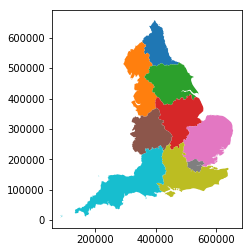

In [21]:
region_shape.plot(column='rgn17cd')